<a href="https://colab.research.google.com/github/ZzangJay/team_project/blob/main/20221119_%EB%AA%A8%EB%8D%B8%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
import gzip
import shutil
import pickle

In [2]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab
cloud_directory = '/content/gdrive/MyDrive/mimiciv_unzip/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

Mounted at /content/gdrive/


['CHANGELOG.txt',
 'LICENSE.txt',
 'SHA256SUMS.txt',
 'index.html',
 'icu',
 'hosp',
 'drop_2_chartevents.csv']

In [11]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/20221119_death_dataset.pickle','rb') as f:
    death_dataset = pickle.load(f)

with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/20221119_anti_dataset.pickle','rb') as f:
    anti_dataset = pickle.load(f)

## train-test 분할

In [5]:
## 학습용 검증용 데이터 나누기 (9:1)
def split_train_test(dataset, train_ratio=0.9, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    pos_idx = np.where(np.array(dataset['LABEL']) == 1)[0]
    neg_idx = np.where(np.array(dataset['LABEL']) == 0)[0]

    # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_num = len(pos_idx)
    neg_num = len(neg_idx)

    train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    train_idx = train_pos_idx + train_neg_idx
    test_idx = test_pos_idx + test_neg_idx
  
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL': np.array(dataset['LABEL'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx],
      'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,2))
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL': np.array(dataset['LABEL'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx],
      'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,2))
  })
  return train_set, test_set

In [6]:
## 학습용 검증용 데이터 나누기 (9:1)
def split_train_test_many(dataset, train_ratio=0.9, pos_neg=True):
  if pos_neg:
    pass
  else:
    idx = np.arange(len(dataset['LABEL_1']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL_1': np.array(dataset['LABEL_1'])[train_idx],
      'LABEL_2': np.array(dataset['LABEL_2'])[train_idx],
      'LABEL_3': np.array(dataset['LABEL_3'])[train_idx],
      'LABEL_4': np.array(dataset['LABEL_4'])[train_idx],
      'LABEL_5': np.array(dataset['LABEL_5'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx],
      'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,2))
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL_1': np.array(dataset['LABEL_1'])[test_idx],
      'LABEL_2': np.array(dataset['LABEL_2'])[test_idx],
      'LABEL_3': np.array(dataset['LABEL_3'])[test_idx],
      'LABEL_4': np.array(dataset['LABEL_4'])[test_idx],
      'LABEL_5': np.array(dataset['LABEL_5'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx],
      'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,2))
  })
  return train_set, test_set

In [12]:
death_train, death_test = split_train_test(death_dataset)
anti_train, anti_test = split_train_test_many(anti_dataset, pos_neg=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

In [13]:
print(len(death_train['HADM_IDS']))
print(len(death_test['HADM_IDS']))
print(len(anti_train['HADM_IDS']))
print(len(anti_test['HADM_IDS']))

print(sum(anti_train['LABEL_1']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_1']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_2']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_2']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_3']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_3']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_4']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_4']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_5']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_5']==1)/len(anti_test['HADM_IDS']))

29105
3235
29106
3234
0.3348106919535491
0.3364254792826221
0.357555143269429
0.3484848484848485
0.1862502576788291
0.17625231910946196
0.11142032570603999
0.11657390228818801
0.05816670102384388
0.06060606060606061


## loader 만들기

In [15]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.3 MB/s 


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.utils import Sequence
import numpy as np
import tensorflow_addons as tfa

In [17]:
## 사망예측 모델용 데이터 로더_static 변수 추가
class Death_Dataloader2(Sequence):
    def __init__(self, x_set,x_set2, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.x2, self.y, self.hadm_id = x_set, x_set2, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        
        batch_x2 = [self.x2[i] for i in indices]

        ## 입력 데이터들의 크기를 최대 24시간으로 통일하고 24시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 24, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        

        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return [np.array(padded_batch_x).astype('float32'), np.array(batch_x2).astype('float32')] ,np.array(batch_y).astype('float32')

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [18]:
## 항생제예측 모델용 데이터 로더_static 변수 추가
class Death_Dataloader_many(Sequence):
    def __init__(self, x_set,x_set2, y_set_1, y_set_2, y_set_3, y_set_4, y_set_5, hadm_id_set, batch_size, shuffle=False):
        self.x, self.x2, self.y_1, self.y_2, self.y_3, self.y_4, self.y_5, self.hadm_id = x_set, x_set2, y_set_1, y_set_2, y_set_3, y_set_4, y_set_5, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        
        batch_x2 = [self.x2[i] for i in indices]

        ## 입력 데이터들의 크기를 최대 24시간으로 통일하고 24시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 24, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        

        batch_y_1 = [self.y_1[i] for i in indices]
        batch_y_2 = [self.y_2[i] for i in indices]
        batch_y_3 = [self.y_3[i] for i in indices]
        batch_y_4 = [self.y_4[i] for i in indices]
        batch_y_5 = [self.y_5[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return [np.array(padded_batch_x).astype('float32'), np.array(batch_x2).astype('float32')] ,[np.array(batch_y_1).astype('float32'),np.array(batch_y_2).astype('float32'),np.array(batch_y_3).astype('float32'),np.array(batch_y_4).astype('float32'),np.array(batch_y_5).astype('float32')]

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)


In [19]:
death_train_loader = Death_Dataloader2(death_train['DATA'], death_train['LABEL'], death_train['HADM_IDS'], 64, True)
death_test_loader = Death_Dataloader2(death_test['DATA'], death_test['LABEL'], death_test['HADM_IDS'], 64, False)
anti_train_loader = Death_Dataloader_many(anti_train['DATA'], anti_train['EXTRA'], anti_train['LABEL_1'], anti_train['LABEL_2'],anti_train['LABEL_3'],anti_train['LABEL_4'],anti_train['LABEL_5'],anti_train['HADM_IDS'], 64, True)
anti_test_loader = Death_Dataloader_many(anti_test['DATA'], anti_test['EXTRA'], anti_test['LABEL_1'], anti_test['LABEL_2'],anti_test['LABEL_3'],anti_test['LABEL_4'],anti_test['LABEL_5'],anti_test['HADM_IDS'], 64, True)

## 항생제별 모델

In [20]:
from keras import backend as k
k.clear_session()

In [21]:
lr_schedule2 = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.02,decay_steps=10000)
optimizer_cosine = keras.optimizers.SGD(learning_rate=lr_schedule2)

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.005,
#     decay_steps=100000,
#     decay_rate=0.96)
# optimizer_decay = keras.optimizers.SGD(learning_rate=lr_schedule)

# lr_schedule3 = keras.optimizers.schedules.CosineDecayRestarts(
#     initial_learning_rate=0.02,first_decay_steps=10, t_mul=2, m_mul=0.9, alpha=0)
# optimizer_cosine = keras.optimizers.SGD(learning_rate=lr_schedule3)


In [22]:
def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(64,return_sequences=True)(input1)
  model1 = layers.LSTM(64)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)
  model1 = layers.Dense(16)(model1)

  input2 = layers.Input(2)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(16)(model2)

  model_add = layers.Add()([model1, model2])
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  #output = layers.Dense(1, activation='sigmoid')(model_add)
  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  model.compile(loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
model3=lstm_bidirect3()

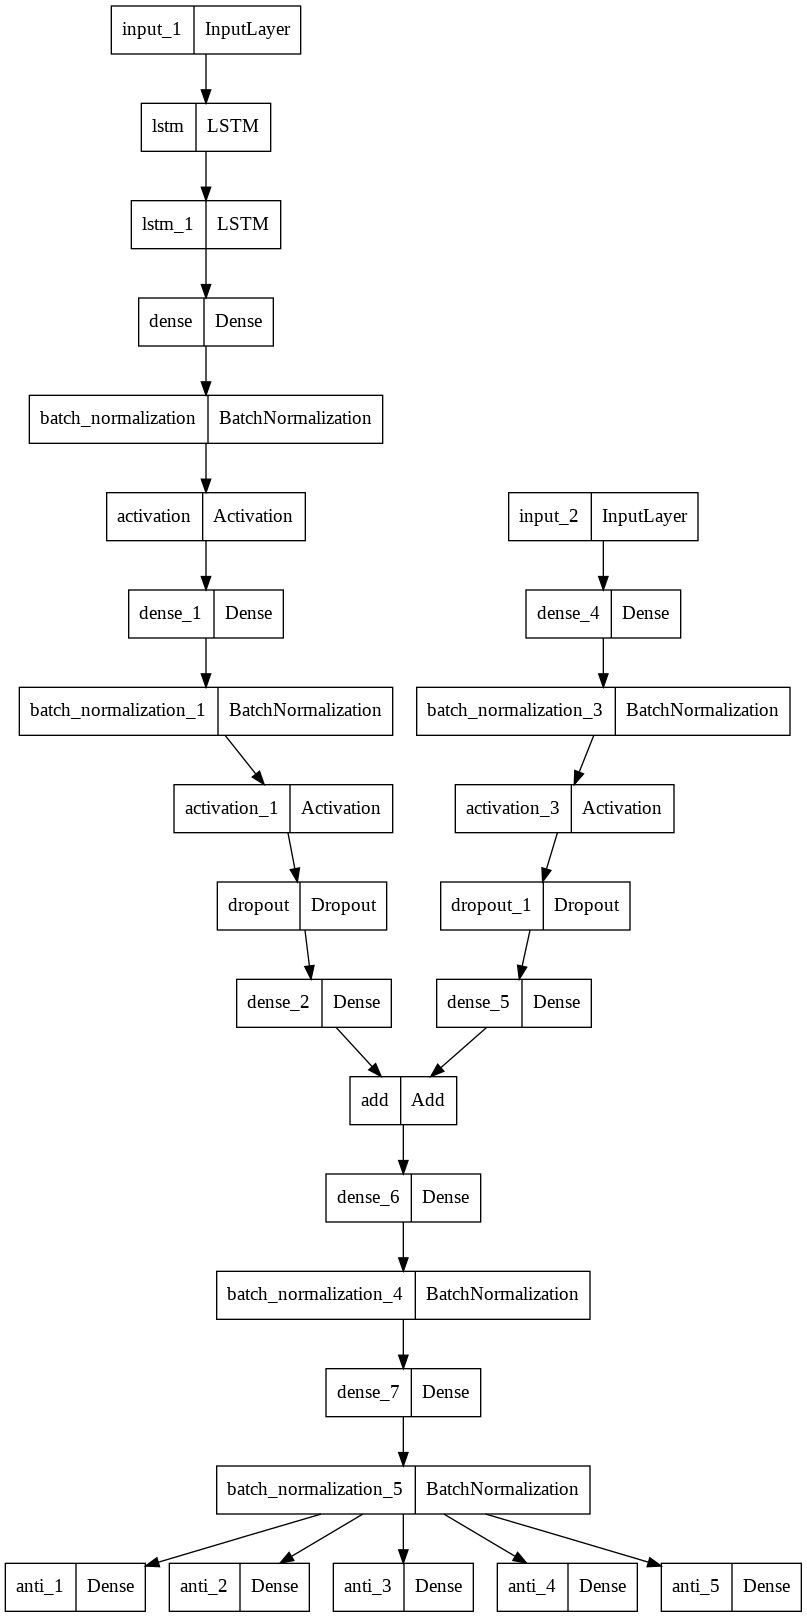

In [ ]:
from keras.utils import plot_model
plot_model(model3, to_file='./model.png')

In [ ]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/anti_model/lstm_model_many.{epoch:02d}-{val_loss:.3f}.h5',save_best_only=True)]

In [ ]:
history_lstm = model3.fit(anti_train_loader,validation_data=anti_test_loader,epochs=500,callbacks=callback,batch_size=64)

Epoch 1/500
455/455 [==============================] - 20s 26ms/step - loss: 2.7133 - anti_1_loss: 0.6187 - anti_2_loss: 0.6621 - anti_3_loss: 0.5280 - anti_4_loss: 0.5270 - anti_5_loss: 0.3774 - anti_1_auc: 0.6371 - anti_2_auc_1: 0.5436 - anti_3_auc_2: 0.5661 - anti_4_auc_3: 0.5185 - anti_5_auc_4: 0.5283 - val_loss: 2.2998 - val_anti_1_loss: 0.5909 - val_anti_2_loss: 0.6428 - val_anti_3_loss: 0.4697 - val_anti_4_loss: 0.3734 - val_anti_5_loss: 0.2230 - val_anti_1_auc: 0.6640 - val_anti_2_auc_1: 0.5902 - val_anti_3_auc_2: 0.6380 - val_anti_4_auc_3: 0.5747 - val_anti_5_auc_4: 0.6822
Epoch 2/500
455/455 [==============================] - 10s 22ms/step - loss: 2.2348 - anti_1_loss: 0.5835 - anti_2_loss: 0.6372 - anti_3_loss: 0.4601 - anti_4_loss: 0.3431 - anti_5_loss: 0.2109 - anti_1_auc: 0.6701 - anti_2_auc_1: 0.5900 - anti_3_auc_2: 0.6354 - anti_4_auc_3: 0.5878 - anti_5_auc_4: 0.6800 - val_loss: 2.2565 - val_anti_1_loss: 0.5757 - val_anti_2_loss: 0.6404 - val_anti_3_loss: 0.4658 - val_a

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history_lstm.history['anti_1_auc'])
plt.plot(history_lstm.history['val_anti_1_auc'])
plt.plot(history_lstm.history['anti_2_auc_1'])
plt.plot(history_lstm.history['val_anti_2_auc_1'])
plt.plot(history_lstm.history['anti_3_auc_2'])
plt.plot(history_lstm.history['val_anti_3_auc_2'])
plt.plot(history_lstm.history['anti_4_auc_3'])
plt.plot(history_lstm.history['val_anti_4_auc_3'])
plt.plot(history_lstm.history['anti_5_auc_4'])
plt.plot(history_lstm.history['val_anti_5_auc_4'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['anti_1_train', 'anti_1_val','anti_2_train', 'anti_2_val','anti_3_train', 'anti_3_val','anti_4_train', 'anti_4_val','anti_5_train', 'anti_5_val'], loc='lower left',bbox_to_anchor=(1, 0))
plt.show()

## 최종모형

In [ ]:
death_train_loader = Death_Dataloader2(death_train['DATA'], death_train['EXTRA'], death_train['LABEL'], death_train['HADM_IDS'], 64, True)
death_test_loader = Death_Dataloader2(death_test['DATA'], death_test['EXTRA'], death_test['LABEL'], death_test['HADM_IDS'], 64, False)

In [ ]:
base_model = keras.models.load_model('/content/gdrive/MyDrive/sepsis_model_weight/lstm_model/lstm_model_many.23-2.217.h5')

In [ ]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 22)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 64)       22272       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           33024       ['lstm[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 32)           2080        ['lstm_1[0][0]']                 
                                                                                              

In [ ]:
def last_model():
    x = base_model(base_model.input,training=False)
    outs = layers.Dense(1, activation='sigmoid',name='death')(base_model.layers[-6].output)
    model = keras.Model(base_model.input, outs)
    model.compile(loss={'death':'binary_crossentropy'},metrics={'death':'AUC'})
  
    return model

model4=last_model()

In [ ]:
optimizers = [
    keras.optimizers.Adam(learning_rate=1e-4),
    keras.optimizers.Adam(learning_rate=1e-2)
]
optimizers_and_layers = [(optimizers[0], model4.layers[0:-1]), (optimizers[1], model4.layers[-1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

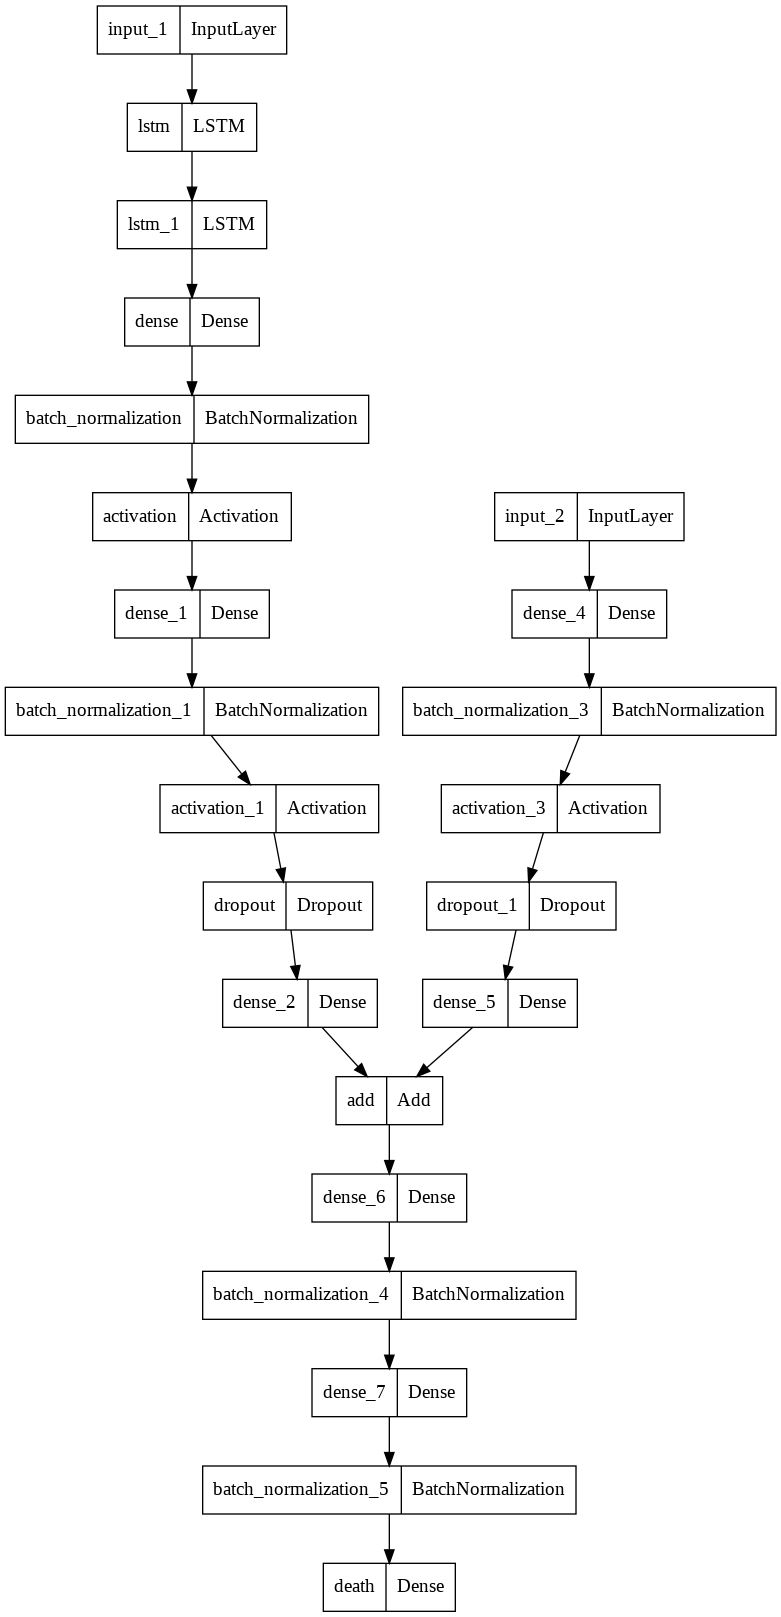

In [ ]:
from keras.utils import plot_model
plot_model(model4, to_file='./model.png')

In [ ]:
history_lstm_re = model4.fit(death_train_loader,validation_data=death_test_loader,epochs=500,callbacks=callback,batch_size=64)

Epoch 1/500
455/455 [==============================] - 13s 17ms/step - loss: 0.4057 - auc: 0.7064 - val_loss: 0.3591 - val_auc: 0.7717
Epoch 2/500
455/455 [==============================] - 7s 15ms/step - loss: 0.3638 - auc: 0.7666 - val_loss: 0.3540 - val_auc: 0.7798
Epoch 3/500
455/455 [==============================] - 7s 14ms/step - loss: 0.3584 - auc: 0.7755 - val_loss: 0.3587 - val_auc: 0.7818
Epoch 4/500
455/455 [==============================] - 7s 15ms/step - loss: 0.3555 - auc: 0.7820 - val_loss: 0.3637 - val_auc: 0.7641
Epoch 5/500
455/455 [==============================] - 7s 15ms/step - loss: 0.3530 - auc: 0.7846 - val_loss: 0.3534 - val_auc: 0.7874
Epoch 6/500
455/455 [==============================] - 7s 14ms/step - loss: 0.3511 - auc: 0.7896 - val_loss: 0.3449 - val_auc: 0.7923
Epoch 7/500
455/455 [==============================] - 7s 14ms/step - loss: 0.3500 - auc: 0.7902 - val_loss: 0.3495 - val_auc: 0.7896
Epoch 8/500
455/455 [==============================] - 6s 14m

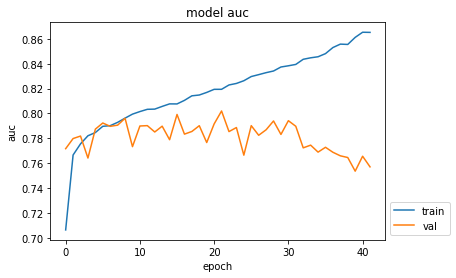

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history_lstm_re.history['auc'])
plt.plot(history_lstm_re.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left',bbox_to_anchor=(1, 0))
plt.show()

## 바로 사망 예측 모델

In [ ]:
# ## 사망예측 모델
# model1 = keras.Sequential([
#    layers.LSTM(16, input_shape=(13,16)),
#    layers.Dense(7, activation='relu')
# ])

# model2 = keras.Sequential([
#    layers.Dense(16, activation='relu',input_shape=[2])
# ])

# # death_lstm = layers.concatenate([model1, model2])
# # death_lstm = layers.Dense(1, activation="sigmoid")(death_lstm)

# # death_lstm = keras.Sequential()
# # death_lstm.add(layers.Merge([model1, model2], mode='concat', concat_axis=-1))

# # death_lstm = keras.Sequential()
# # death_lstm.add()([model1, model2])

# death_lstm = keras.Sequential(
#    layers.Concatenate([model1, model2]),
#    layers.Dense(1, activation='sigmoid')
# )
# # merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
# death_lstm.summary()

# def lstm_model(tem_train, dem_train):
#     temporal_input_layer = Input(shape=(13 , 16))
#     main_rnn_layer = layers.LSTM(64, return_sequences=True)(temporal_input_layer) #recurrent_dropout=0.2
#     rnn_f = layers.LSTM(32)(main_rnn_layer)

#     demographic_input_layer = Input(shape=(2))
#     demographic_dense = layers.Dense(16)(demographic_input_layer)
#     demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#     #fatality output branch
#     merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
#     dense_f = layers.Dense(128)(merge_f)
#     dropout_f = layers.Dropout(0.2)(dense_f)
#     output = layers.Dense(1, activation='sigmoid', name="output")(dropout_f)

#     model = keras.Model([temporal_input_layer,demographic_input_layer], output)

#     model.summary()
#     return model

# ## 사망예측 모델
# model1 = keras.Sequential([
#    layers.LSTM(16, input_shape=(13,16)),
#    layers.Dense(7, activation='relu')
# ])

# model2 = keras.Sequential([
#    layers.Dense(16, activation='relu',input_shape=[2])
# ])

# # death_lstm = layers.concatenate([model1, model2])
# # death_lstm = layers.Dense(1, activation="sigmoid")(death_lstm)

# # death_lstm = keras.Sequential()
# # death_lstm.add(layers.Merge([model1, model2], mode='concat', concat_axis=-1))

# # death_lstm = keras.Sequential()
# # death_lstm.add()([model1, model2])

# death_lstm = keras.Sequential(
#    layers.Concatenate([model1, model2]),
#    layers.Dense(1, activation='sigmoid')
# )
# # merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
# death_lstm.summary()

In [ ]:
## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125, activation='relu'),
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.2),
#    #batch normalization, dropout,optimizer deat
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

# ## 사망예측 모델
# death_lstm_re = keras.Sequential([
#     layers.LSTM(64, input_shape=(13,27), return_sequences=True),
#     layers.LSTM(64),
#     layers.Dense(32),
#     layers.BatchNormalization(),
#     layers.Activation('tanh'),
#     layers.Dropout(0.1),
#     layers.Dense(1, activation='sigmoid')
# ])
# death_lstm_re.summary()

# ## 사망예측 모델
# death_lstm_re = keras.Sequential([
#     layers.LSTM(16, input_shape=(13,27), return_sequences=True),
#     layers.LSTM(16, return_sequences=True),
#     layers.LSTM(16, return_sequences=True),
#     layers.LSTM(16),
#     layers.Dense(16),
#     layers.BatchNormalization(),
#     layers.Activation('tanh'),
#     layers.Dropout(0.1),
#     #batch normalization, dropout,optimizer deat
#     layers.Dense(1, activation='sigmoid')
# ])
# death_lstm_re.summary()

# ## 사망예측 모델
# death_lstm_re = keras.Sequential([
#     layers.LSTM(256, input_shape=(13,16), return_sequences=True),
#     layers.LSTM(256),
#     layers.Dense(128),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.2),
#     layers.Dense(128),  
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.2),
#     #batch normalization, dropout,optimizer deat
#     layers.Dense(1, activation='sigmoid')
# ])
# death_lstm_re.summary()

## 사망예측 모델
#death_lstm_re = keras.Sequential([
#    layers.LSTM(256, input_shape=(13,16), return_sequences=True),
#    layers.LSTM(256, return_sequences=True),
#    layers.LSTM(256),
#    layers.Dense(128),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.1),
#    layers.Dense(128),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.1),
#    #batch normalization, dropout,optimizer deat
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm_re.summary()

## 사망예측 모델 학습
# #death_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# #keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
# #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
# #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
# #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)

# death_lstm_re.compile(loss='binary_crossentropy', optimizer=adam, metrics=['AUC'])

# #num_epochs = 100
# num_epochs = 70 
# #num_epochs = 200
# # history = death_lstm_re.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2, validation_split=0.1)
# history = death_lstm_re.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2, validation_split=0.1)

## 약제별 분석 사망자 예측

In [ ]:
cepha_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

glyco_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

peni_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

fluoro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

macro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})
list_glyco=[]
for i in id_glyco['hadm_id']:
  list_glyco.append(i)

list_cepha=[]
for i in id_cepha['hadm_id']:
  list_cepha.append(i)

list_peni=[]
for i in id_peni['hadm_id']:
  list_peni.append(i)

list_fluoro=[]
for i in id_fluoro['hadm_id']:
  list_fluoro.append(i)

list_macro=[]
for i in id_macro['hadm_id']:
  list_macro.append(i)

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Glycopeptides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_glyco) == True:
      glyco_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      glyco_dataset['LABEL'].append(death_dataset['LABEL'][i])
      glyco_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Cephalosporins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_cepha) == True:
      cepha_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      cepha_dataset['LABEL'].append(death_dataset['LABEL'][i])
      cepha_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Penicillins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_peni) == True:
      peni_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      peni_dataset['LABEL'].append(death_dataset['LABEL'][i])
      peni_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Fluoroquinolones Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_fluoro) == True:
      fluoro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      fluoro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      fluoro_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Macrolides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_macro) == True:
      macro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      macro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      macro_dataset['DATA'].append(death_dataset['DATA'][i])

print(len(glyco_dataset['HADM_IDS']))
print(len(cepha_dataset['HADM_IDS']))
print(len(peni_dataset['HADM_IDS']))
print(len(fluoro_dataset['HADM_IDS']))
print(len(macro_dataset['HADM_IDS']))

In [ ]:
glyco_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cepha_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

peni_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

fluoro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

macro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
#@title 약제별 분석


glyco_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = glyco_lstm.fit(glyco_train_loader, validation_data=glyco_test_loader, epochs=num_epochs, verbose=2)


cepha_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = cepha_lstm.fit(cepha_train_loader, validation_data=cepha_test_loader, epochs=num_epochs, verbose=2)


peni_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = peni_lstm.fit(peni_train_loader, validation_data=peni_test_loader, epochs=num_epochs, verbose=2)

fluoro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = fluoro_lstm.fit(fluoro_train_loader, validation_data=fluoro_test_loader, epochs=num_epochs, verbose=2)

macro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = macro_lstm.fit(macro_train_loader, validation_data=macro_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
glyco_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_glyco.h5')
cepha_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_cepha.h5')
peni_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_peni.h5')
fluoro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_fluoro.h5')
macro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_macro.h5')

In [ ]:
glyco_label=pd.DataFrame(glyco_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(glyco_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(glyco_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(glyco_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(glyco_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(glyco_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(glyco_test_loader))

19/19 [==============================] - 0s 4ms/step


In [ ]:
glyco_total=pd.concat([glyco_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
glyco_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
glyco_total

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
0,1,0.014108,0.223974,0.092540,0.349622,0.311748,0.180778
1,1,0.485061,0.470382,0.522545,0.205113,0.142648,0.128929
2,1,0.356203,0.426065,0.678691,0.231644,0.217998,0.113417
3,1,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
4,1,0.193229,0.137318,0.205912,0.104218,0.109623,0.064443
...,...,...,...,...,...,...,...
2347,0,0.157966,0.136068,0.127145,0.076348,0.094608,0.062250
2348,0,0.152380,0.152679,0.114211,0.131388,0.103832,0.099097
2349,0,0.262742,0.167690,0.180576,0.158227,0.145779,0.119568
2350,0,0.186726,0.192592,0.222549,0.164990,0.206763,0.104039


In [ ]:
glyco_total.to_csv('glyco_total.csv')

In [ ]:
glyco_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000
mean,0.215986,0.196350,0.214887,0.186830,0.198750,0.176921,0.142387
std,0.411592,0.170452,0.158309,0.153455,0.152484,0.155931,0.126896
min,0.000000,0.001662,0.015854,0.000040,0.003022,0.043336,0.002842
25%,0.000000,0.106631,0.149175,0.122726,0.139193,0.108697,0.096551
50%,0.000000,0.164574,0.163080,0.135749,0.144958,0.112443,0.103486
75%,0.000000,0.195743,0.181829,0.198761,0.177399,0.180022,0.125479
max,1.000000,0.999955,0.999038,0.994983,0.988274,0.999859,0.991618


In [ ]:
cepha_label=pd.DataFrame(cepha_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(cepha_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(cepha_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(cepha_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(cepha_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(cepha_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(cepha_test_loader))

18/18 [==============================] - 0s 4ms/step


In [ ]:
cepha_total=pd.concat([cepha_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
cepha_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
cepha_total

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
0,1,0.236570,0.148248,0.279651,0.132168,0.122248,0.086393
1,1,0.410458,0.297525,0.233613,0.239752,0.316624,0.117778
2,1,0.999856,0.895030,0.984093,0.980664,0.999827,0.656816
3,1,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
4,1,0.237204,0.201668,0.251227,0.167174,0.294863,0.145911
...,...,...,...,...,...,...,...
2187,0,0.077487,0.146791,0.097477,0.153996,0.095492,0.111025
2188,0,0.263328,0.408858,0.108774,0.162515,0.205582,0.099497
2189,0,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
2190,0,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486


In [ ]:
cepha_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,0.148266,0.153331,0.193897,0.146789,0.186245,0.165484,0.136834
std,0.355445,0.141966,0.128466,0.128426,0.124085,0.127099,0.117513
min,0.000000,0.004505,0.014203,0.000041,0.003430,0.041863,0.002022
25%,0.000000,0.071000,0.145172,0.085396,0.136709,0.108039,0.091566
50%,0.000000,0.128333,0.163080,0.122726,0.144958,0.115422,0.103486
75%,0.000000,0.195743,0.174878,0.166112,0.178013,0.180804,0.127038
max,1.000000,0.999952,0.998940,0.993771,0.988274,0.999858,0.989579


In [ ]:
peni_label=pd.DataFrame(peni_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(peni_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(peni_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(peni_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(peni_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(peni_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(peni_test_loader))

10/10 [==============================] - 0s 4ms/step


In [ ]:
peni_total=pd.concat([peni_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
peni_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
peni_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,0.206101,0.185862,0.207560,0.182194,0.188175,0.174800,0.137230
std,0.404670,0.161580,0.148215,0.141028,0.136850,0.147643,0.122632
min,0.000000,0.006523,0.013199,0.000043,0.000992,0.032825,0.001846
25%,0.000000,0.100963,0.147211,0.122726,0.134231,0.107627,0.092442
50%,0.000000,0.141116,0.163080,0.138982,0.144958,0.117527,0.103486
75%,0.000000,0.195743,0.182099,0.195352,0.174253,0.183134,0.127393
max,1.000000,0.999936,0.998780,0.994983,0.988192,0.999842,0.994304


In [ ]:
cepha_total.to_csv('glyco_total.csv')

In [ ]:
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')

In [ ]:
sum(death_train['LABEL'])/len(death_train['LABEL'])

0.15838639569908872

모델 저장과
test data로 test( 5개 모델간 차이가 있는지)